# CONSENSUS ANALYSIS OF CASSETTES

In [85]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# Reading clustering files
cassettes_r60 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res60_cassettes.csv", index_col=0)
cassettes_r100 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res100_cassettes.csv", index_col=0)
cassettes_r120 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res120_cassettes.csv", index_col=0)
cassettes_r140 = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/n_res140_cassettes.csv", index_col=0)

In [87]:
# Reading original distal cassettes (N=235, Beta = 10)
cassettes_original =  pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_beta10_n235.csv", index_col=0)

In [88]:
# Reading top variance cpgs to show
top_5000_cpgs = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_top_var_5000.txt", header=None)
top_10000_cpgs = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_top_var_10000.txt", header=None)
top_30000_cpgs = pd.read_csv("/Users/isasiain/PhD/Projects/project_3/analysis/cassettes_resampling/consensus/distal_top_var_30000.txt", header=None)

### CONSENSUS ACROSS RESAMPLINGS

In [89]:
# Step 1: Convert to list
cpg_list = top_10000_cpgs.iloc[:, 0].to_list()

# Step 2: Filter to those in index of cassettes_r60
filtered_cpgs = [cpg for cpg in cpg_list if cpg in cassettes_r60.index]

In [90]:
cassettes_r60 = cassettes_r60.loc[filtered_cpgs,]

In [91]:
# WITHOUT NORMALIZATION

# Step 1: Setup
ids = list(cassettes_r60.index)  # CpG identifiers
n = len(ids)  # Number of CpGs
id_to_idx = dict(zip(ids, range(n)))  # Map CpG labels to matrix indices

# This will store co-clustering counts only (no normalizing)
pair_counts = defaultdict(int)

# Step 2: Iterate through each clustering result (each column in DataFrame)
for col in cassettes_r60.columns:

    clustering = cassettes_r60[col].dropna()  # Drop NaN values (CpGs not present in this clustering)
    
    # List of CpGs in this clustering run (after dropping NaNs)
    present_ids = clustering.index.tolist()  # The CpGs present in this clustering

    # Step 3: Count co-clustered CpGs
    for i in range(len(present_ids)):
        for j in range(i + 1, len(present_ids)):
            id1, id2 = present_ids[i], present_ids[j]
            idx1, idx2 = id_to_idx[id1], id_to_idx[id2]

            if clustering[id1] == clustering[id2]:
                pair_counts[(idx1, idx2)] += 1
                pair_counts[(idx2, idx1)] += 1

# Step 4: Build COO sparse matrix from counts
row_idx = []
col_idx = []
data = []

for (i, j), count in pair_counts.items():
    row_idx.append(i)
    col_idx.append(j)
    data.append(count)

consensus_matrix = coo_matrix((data, (row_idx, col_idx)), shape=(n, n))
print(consensus_matrix)

KeyboardInterrupt: 

/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


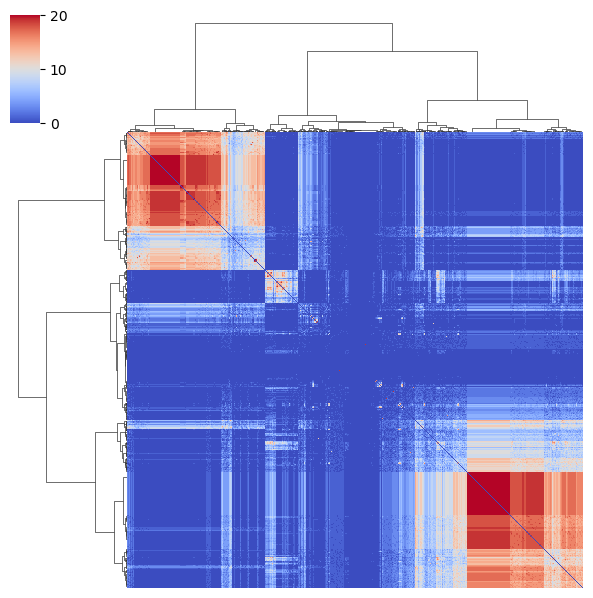

In [ ]:
# Convert to dense array for plotting
consensus_matrix_dense = consensus_matrix.toarray()

sns.clustermap(consensus_matrix_dense, 
               cmap="coolwarm", 
               method="ward", 
               metric="euclidean", 
               figsize=(6, 6),
               xticklabels=False, yticklabels=False
               )
plt.show()

In [ ]:
# WITH NORMALIZATION

# Step 1: Setup
ids = list(cassettes_r60.index)
n = len(ids)
id_to_idx = dict(zip(ids, range(n)))

pair_counts = defaultdict(int)
pair_total = defaultdict(int)  # Count of times both CpGs were present

# Step 2: Iterate through each clustering result
for col in cassettes_r60.columns:
    clustering = cassettes_r60[col].dropna()
    present_ids = clustering.index.tolist()
    
    for i in range(len(present_ids)):
        for j in range(i + 1, len(present_ids)):
            id1, id2 = present_ids[i], present_ids[j]
            idx1, idx2 = id_to_idx[id1], id_to_idx[id2]
            
            pair_total[(idx1, idx2)] += 1
            pair_total[(idx2, idx1)] += 1
            
            if clustering[id1] == clustering[id2]:
                pair_counts[(idx1, idx2)] += 1
                pair_counts[(idx2, idx1)] += 1

# Step 4: Build normalized COO sparse matrix
row_idx = []
col_idx = []
data = []

for (i, j), count in pair_counts.items():
    total = pair_total[(i, j)]
    if total > 0:
        row_idx.append(i)
        col_idx.append(j)
        data.append(count / total)  # Normalize

consensus_matrix = coo_matrix((data, (row_idx, col_idx)), shape=(n, n))
print(consensus_matrix)


<COOrdinate sparse matrix of dtype 'float64'
	with 55087520 stored elements and shape (10000, 10000)>
  Coords	Values
  (0, 3529)	0.7
  (3529, 0)	0.7
  (1, 3)	0.8
  (3, 1)	0.8
  (1, 11)	1.0
  (11, 1)	1.0
  (1, 12)	0.35
  (12, 1)	0.35
  (1, 20)	0.8
  (20, 1)	0.8
  (1, 22)	0.95
  (22, 1)	0.95
  (1, 23)	0.5
  (23, 1)	0.5
  (1, 24)	0.25
  (24, 1)	0.25
  (1, 25)	1.0
  (25, 1)	1.0
  (1, 28)	0.35
  (28, 1)	0.35
  (1, 34)	0.65
  (34, 1)	0.65
  (1, 43)	0.65
  (43, 1)	0.65
  (1, 48)	0.5
  :	:
  (9968, 9944)	0.08333333333333333
  (9945, 9968)	0.08333333333333333
  (9968, 9945)	0.08333333333333333
  (9947, 9998)	0.05
  (9998, 9947)	0.05
  (9956, 9968)	0.08333333333333333
  (9968, 9956)	0.08333333333333333
  (9963, 9968)	0.08333333333333333
  (9968, 9963)	0.08333333333333333
  (9968, 9988)	0.08333333333333333
  (9988, 9968)	0.08333333333333333
  (9968, 9989)	0.08333333333333333
  (9989, 9968)	0.08333333333333333
  (9968, 9993)	0.08333333333333333
  (9993, 9968)	0.08333333333333333
  (9968, 9998)	0.

/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


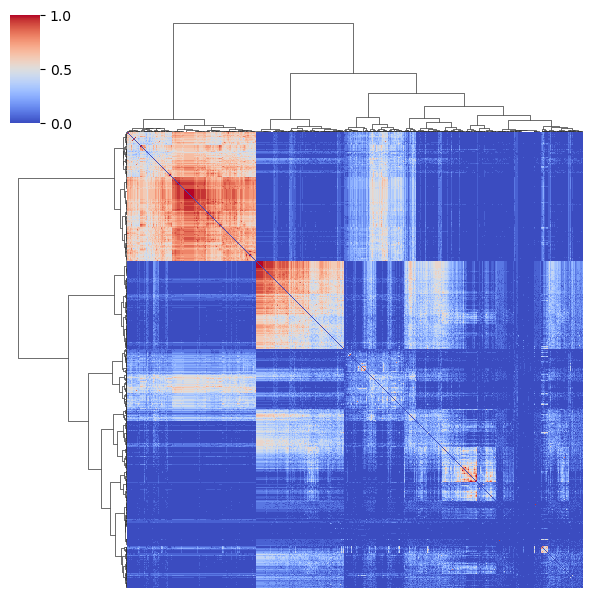

In [ ]:
# Convert to dense array for plotting
consensus_matrix_dense = consensus_matrix.toarray()

sns.clustermap(consensus_matrix_dense, 
               cmap="coolwarm", 
               method="ward", 
               metric="euclidean", 
               figsize=(6, 6),
               xticklabels=False, yticklabels=False
               )
plt.show()

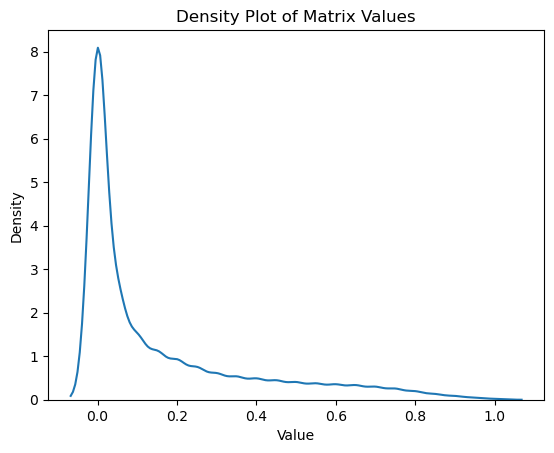

In [ ]:
# Flatten the consensus matrix to 1D
values = consensus_matrix_dense.flatten()

# Plot density plot
sns.kdeplot(values, bw_adjust=4)  
plt.title("Density Plot of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

### CONSENSUS BETWEEN RESAMLINGS AND ORIGINAL CASSETTES

1. R = 60

In [142]:
# CASSETTE 1
cpg_list = cassettes_original.loc[(cassettes_original["Cassettes"] == 3), "CpG"]

# Filter to those in index of cassettes_r60
filtered_cpgs = [cpg for cpg in cpg_list if cpg in cassettes_r100.index]

# Keeping only CpGs of interest
cassettes_r60_filtered = cassettes_r100.loc[filtered_cpgs,]

# Replace 0 with NA
cassettes_r140_filtered = cassettes_r140_filtered.replace(0, np.nan)

# Analyse consensus

## Step 1: Setup
ids = list(cassettes_r60_filtered.index)
n = len(ids)
id_to_idx = dict(zip(ids, range(n)))

pair_counts = defaultdict(int)
pair_total = defaultdict(int)  # Count of times both CpGs were present

## Step 2: Iterate through each clustering result
for col in cassettes_r60_filtered.columns:
    clustering = cassettes_r60_filtered[col].dropna()
    present_ids = clustering.index.tolist()
    
    for i in range(len(present_ids)):
        for j in range(i + 1, len(present_ids)):
            id1, id2 = present_ids[i], present_ids[j]
            idx1, idx2 = id_to_idx[id1], id_to_idx[id2]
            
            pair_total[(idx1, idx2)] += 1
            pair_total[(idx2, idx1)] += 1
            
            if clustering[id1] == clustering[id2]:
                pair_counts[(idx1, idx2)] += 1
                pair_counts[(idx2, idx1)] += 1

## Step 4: Build normalized COO sparse matrix
row_idx = []
col_idx = []
data = []

for (i, j), count in pair_counts.items():
    total = pair_total[(i, j)]
    if total > 0:
        row_idx.append(i)
        col_idx.append(j)
        #data.append(count / total)  # Normalize
        data.append(count)  # Normalize

consensus_matrix = coo_matrix((data, (row_idx, col_idx)), shape=(n, n))
print(consensus_matrix)

<COOrdinate sparse matrix of dtype 'int64'
	with 592586 stored elements and shape (800, 800)>
  Coords	Values
  (0, 1)	7
  (1, 0)	7
  (0, 2)	8
  (2, 0)	8
  (0, 7)	9
  (7, 0)	9
  (0, 8)	9
  (8, 0)	9
  (0, 9)	10
  (9, 0)	10
  (0, 10)	4
  (10, 0)	4
  (0, 12)	12
  (12, 0)	12
  (0, 14)	5
  (14, 0)	5
  (0, 15)	6
  (15, 0)	6
  (0, 16)	8
  (16, 0)	8
  (0, 17)	10
  (17, 0)	10
  (0, 18)	11
  (18, 0)	11
  (0, 20)	10
  :	:
  (777, 749)	1
  (749, 778)	1
  (778, 749)	1
  (749, 780)	1
  (780, 749)	1
  (749, 786)	1
  (786, 749)	1
  (756, 786)	1
  (786, 756)	1
  (756, 798)	1
  (798, 756)	1
  (762, 786)	1
  (786, 762)	1
  (778, 786)	1
  (786, 778)	1
  (780, 786)	1
  (786, 780)	1
  (780, 798)	1
  (798, 780)	1
  (786, 797)	1
  (797, 786)	1
  (786, 798)	1
  (798, 786)	1
  (788, 798)	1
  (798, 788)	1


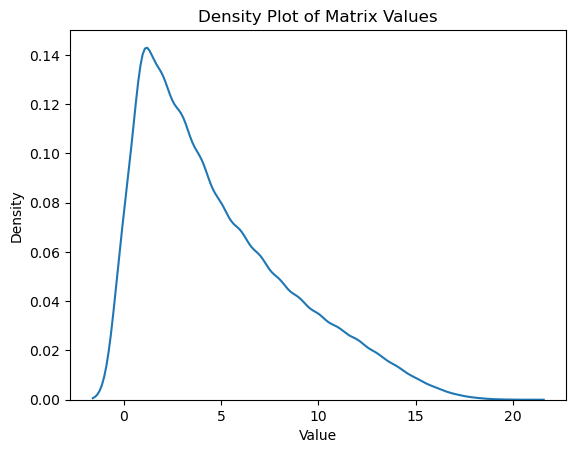

In [144]:
# Flatten the consensus matrix to 1D
consensus_matrix_dense = consensus_matrix.toarray()
values = consensus_matrix_dense.flatten()

# Plot density plot
sns.kdeplot(values, bw_adjust=2)  
plt.title("Density Plot of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


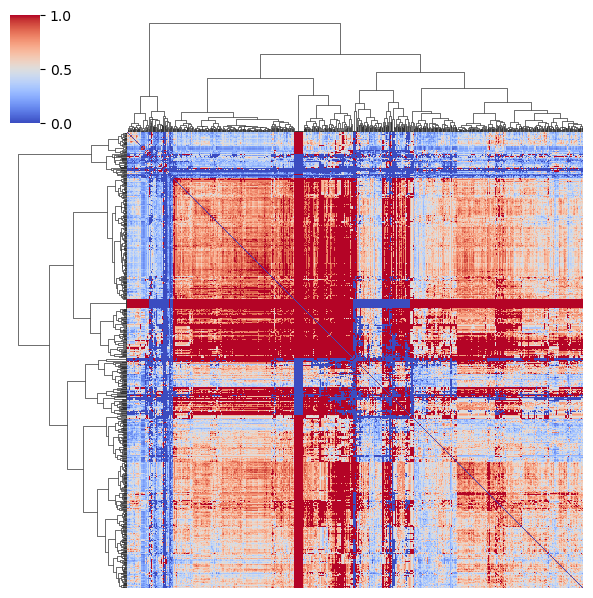

In [141]:
# Convert to dense array for plotting
consensus_matrix_dense = consensus_matrix.toarray()

sns.clustermap(consensus_matrix_dense, 
               cmap="coolwarm", 
               method="ward", 
               metric="euclidean", 
               figsize=(6, 6),
               xticklabels=False, yticklabels=False
               )
plt.show()

2. R = 140

In [135]:
import numpy as np
from collections import defaultdict
from scipy.sparse import coo_matrix

# CASSETTE 1
cpg_list = cassettes_original.loc[(cassettes_original["Cassettes"] == 3), "CpG"]

# Filter to those in index of cassettes_r140
filtered_cpgs = [cpg for cpg in cpg_list if cpg in cassettes_r140.index]

# Subset
cassettes_r140_filtered = cassettes_r140.loc[filtered_cpgs, :]

# Keep only CpGs with non-NA values in at least 50% of the columns
min_present = cassettes_r140_filtered.shape[1] * 0.5
cassettes_r140_filtered = cassettes_r140_filtered[cassettes_r140_filtered.notna().sum(axis=1) >= min_present]

# Analyse consensus
ids = list(cassettes_r140_filtered.index)
n = len(ids)
id_to_idx = dict(zip(ids, range(n)))

pair_counts = defaultdict(int)
pair_total = defaultdict(int)

# Iterate through each clustering result
for col in cassettes_r140_filtered.columns:
    clustering = cassettes_r140_filtered[col].dropna()
    present_ids = clustering.index.tolist()
    
    for i in range(len(present_ids)):
        for j in range(i + 1, len(present_ids)):
            id1, id2 = present_ids[i], present_ids[j]
            idx1, idx2 = id_to_idx[id1], id_to_idx[id2]
            
            pair_total[(idx1, idx2)] += 1
            pair_total[(idx2, idx1)] += 1
            
            if clustering[id1] == clustering[id2]:
                pair_counts[(idx1, idx2)] += 1
                pair_counts[(idx2, idx1)] += 1

# Build normalized COO sparse matrix
row_idx = []
col_idx = []
data = []

for (i, j), count in pair_counts.items():
    total = pair_total[(i, j)]
    if total > 0:
        row_idx.append(i)
        col_idx.append(j)
        data.append(count / total)

consensus_matrix = coo_matrix((data, (row_idx, col_idx)), shape=(n, n))
print(consensus_matrix)


<COOrdinate sparse matrix of dtype 'float64'
	with 301756 stored elements and shape (552, 552)>
  Coords	Values
  (0, 4)	0.85
  (4, 0)	0.85
  (0, 5)	0.85
  (5, 0)	0.85
  (0, 6)	0.9
  (6, 0)	0.9
  (0, 7)	0.95
  (7, 0)	0.95
  (0, 10)	0.8
  (10, 0)	0.8
  (0, 11)	0.75
  (11, 0)	0.75
  (0, 13)	0.8
  (13, 0)	0.8
  (0, 14)	0.7857142857142857
  (14, 0)	0.7857142857142857
  (0, 15)	1.0
  (15, 0)	1.0
  (0, 16)	0.9375
  (16, 0)	0.9375
  (0, 17)	0.8888888888888888
  (17, 0)	0.8888888888888888
  (0, 19)	1.0
  (19, 0)	1.0
  (0, 22)	1.0
  :	:
  (515, 484)	0.07692307692307693
  (484, 517)	0.07692307692307693
  (517, 484)	0.07692307692307693
  (484, 519)	0.1
  (519, 484)	0.1
  (484, 520)	0.08333333333333333
  (520, 484)	0.08333333333333333
  (484, 522)	0.07692307692307693
  (522, 484)	0.07692307692307693
  (484, 526)	0.09090909090909091
  (526, 484)	0.09090909090909091
  (484, 538)	0.07692307692307693
  (538, 484)	0.07692307692307693
  (484, 542)	0.1111111111111111
  (542, 484)	0.1111111111111111
  (48

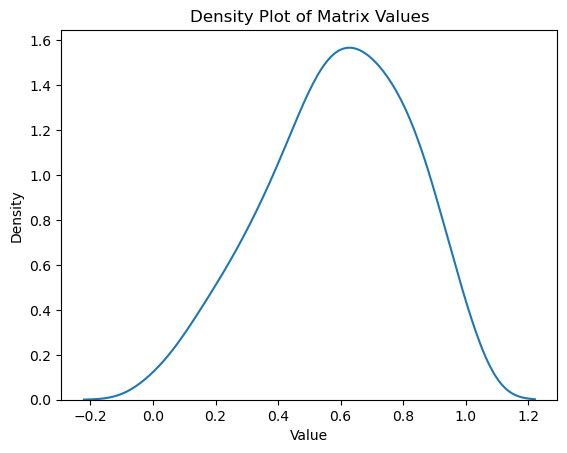

In [136]:
# Flatten the consensus matrix to 1D
consensus_matrix_dense = consensus_matrix.toarray()
values = consensus_matrix_dense.flatten()

# Plot density plot
sns.kdeplot(values, bw_adjust=4)  
plt.title("Density Plot of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/isasiain/miniconda3/envs/cassettes/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


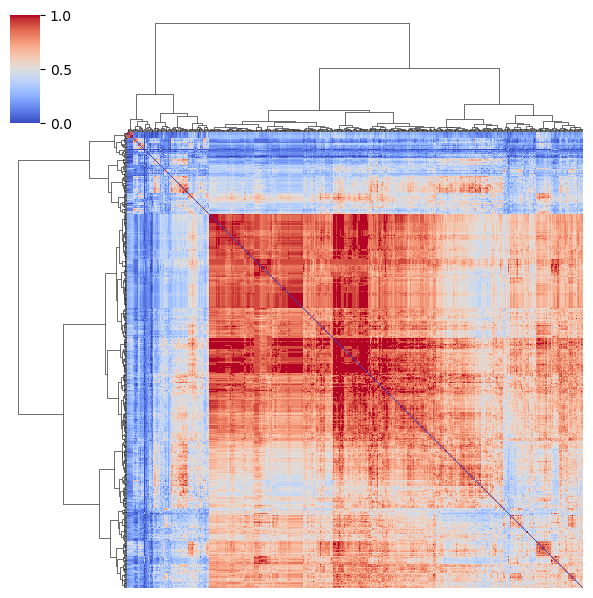

In [137]:
# Convert to dense array for plotting
consensus_matrix_dense = consensus_matrix.toarray()

sns.clustermap(consensus_matrix_dense, 
               cmap="coolwarm", 
               method="ward", 
               metric="euclidean", 
               figsize=(6, 6),
               xticklabels=False, yticklabels=False
               )
plt.show()

/var/folders/y6/k4cdb28d1qz56qw4jx2fxcxr0000gn/T/ipykernel_1529/3805772821.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

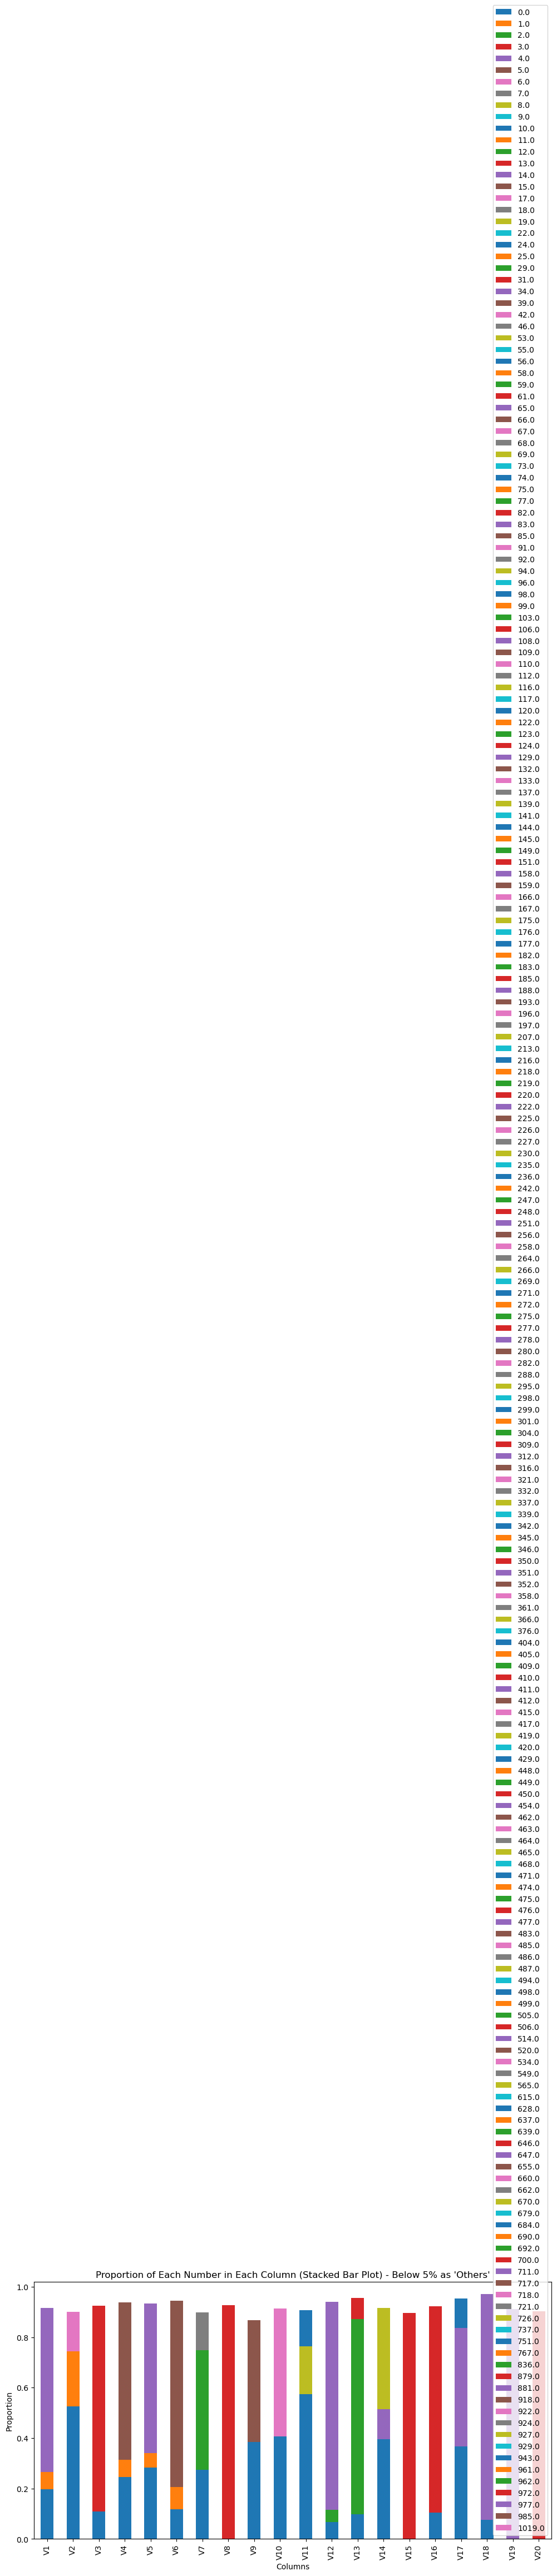

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the proportion of each unique number in each column
proportions = cassettes_r140_filtered.apply(lambda x: x.value_counts(normalize=True))

# Group values with proportions below 5% as 'Others'
proportions = proportions.apply(lambda x: x.where(x > 0.05, 0))  # Set values below 5% to 0
others = proportions.apply(lambda x: (x[x <= 0.05]).sum(), axis=1)  # Sum values below 5%

# Add 'Others' column to the proportions DataFrame
proportions['Others'] = others

# Drop the columns with values below 5% (those that have been set to 0)
proportions = proportions.loc[:, (proportions != 0).any(axis=0)]

# Plot the stacked barplot
plt.figure(figsize=(12, 6))
proportions.T.plot(kind='bar', stacked=True, figsize=(12, 6))

# Labeling the plot
plt.title("Proportion of Each Number in Each Column (Stacked Bar Plot) - Below 5% as 'Others'")
plt.xlabel("Columns")
plt.ylabel("Proportion")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [131]:
proportions

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0.0,0.196498,0.526733,0.109568,0.244944,0.282946,0.117229,0.275269,0.000000,0.383886,0.407674,0.57346,0.066190,0.098097,0.395197,0.000000,0.105536,0.367965,0.076923,0.000000,0.000000
1.0,0.070039,0.217822,0.000000,0.069663,0.058140,0.088810,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.473118,0.000000,0.000000,0.000000,0.00000,0.050089,0.773060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,0.814815,0.000000,0.000000,0.000000,0.000000,0.926593,0.000000,0.000000,0.00000,0.000000,0.083455,0.000000,0.896084,0.816609,0.000000,0.000000,0.000000,0.902632
4.0,0.649805,0.000000,0.000000,0.000000,0.593023,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.824687,0.000000,0.120087,0.000000,0.000000,0.467532,0.892977,0.911038,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
972.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
977.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
985.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
